# Doing Bayesian Data Analysis

Simple example from __Chapter 16__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

# Kruschke's light blue color
sns.set_palette(["#87ceeb"])
sns.set_context("talk")

In [2]:
df = pd.read_csv("data/TwoGroupIQ.csv")
# Only work with the "Smart Drug" group
df = df[df.Group == "Smart Drug"]

print len(df)
df.head()

63


,Score,Group
0,102,Smart Drug
1,107,Smart Drug
2,92,Smart Drug
3,101,Smart Drug
4,110,Smart Drug


In [3]:
with pm.Model() as model:
    # Priors
    sigma = pm.Uniform("sigma", df.Score.std() / 1000, df.Score.std() * 1000)
    mu = pm.Normal("mu", mu=0, tau=1E-8)
    # Likelihood
    y = pm.Normal("y", mu=mu, sd=sigma, observed=df.Score)
    # Sample
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start)
    
burn_in = 5000
trace = trace[burn_in:]

Optimization terminated successfully.
         Current function value: 309.833431
         Iterations: 16
         Function evaluations: 29
         Gradient evaluations: 29


100%|██████████| 10000/10000 [00:01<00:00, 6251.41it/s]


             mean        sd  mc_error     hpd_2.5    hpd_97.5
mu     107.730039  3.097721  0.076870  101.600958  113.419433
sigma   25.813262  2.364924  0.072883   21.569025   30.585283


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11252a8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1126a98d0>]], dtype=object)

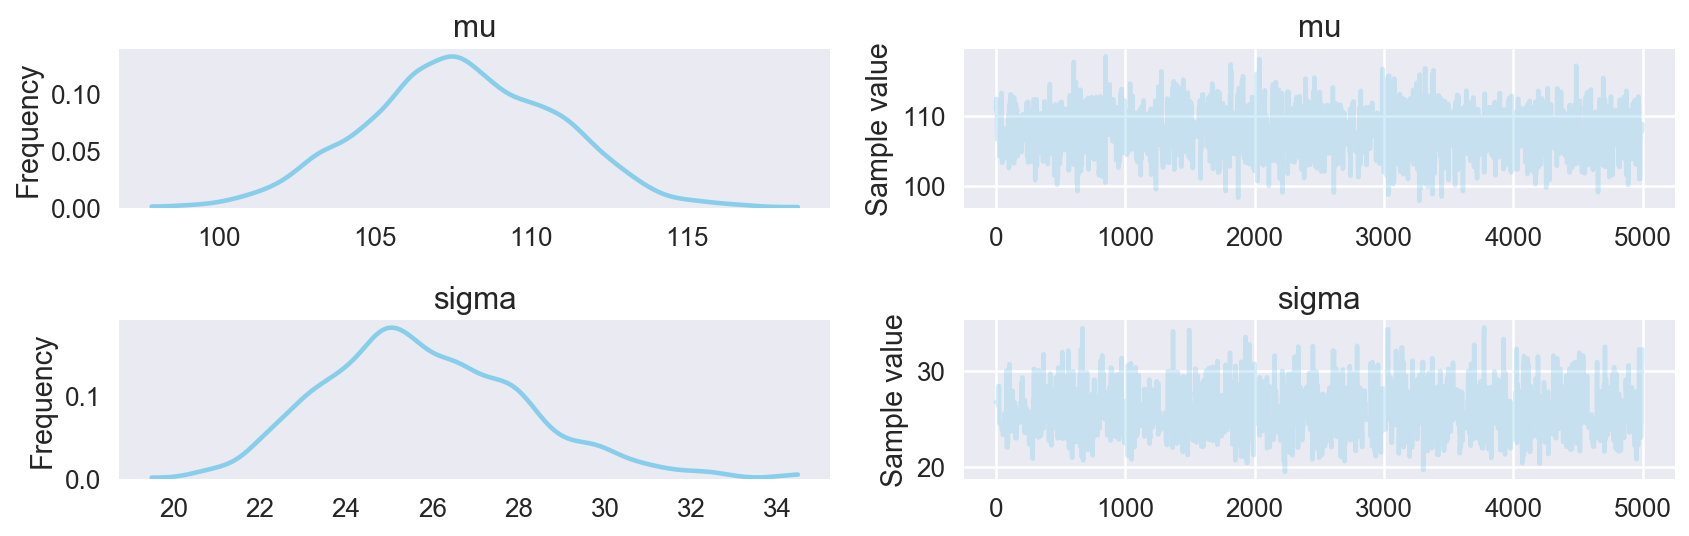

In [4]:
print pm.df_summary(trace)
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11251cc50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1130befd0>], dtype=object)

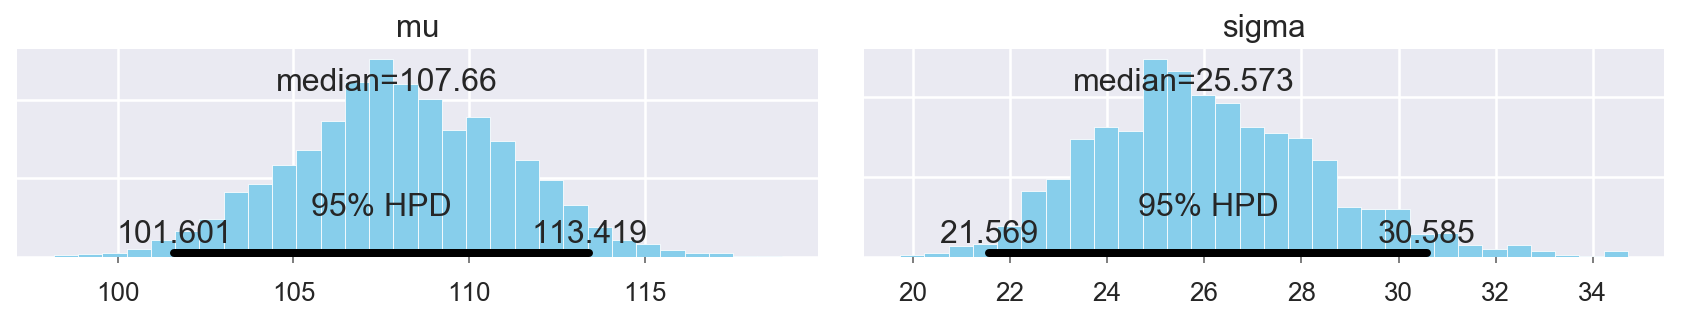

In [5]:
pm.plot_posterior(trace, point_estimate="median")

### Robust Estimation

Use the `StudentT` distribution for likelihood.

In [6]:
with pm.Model() as robust_model:
    # Priors
    sigma = pm.HalfCauchy("sigma", 25)
    mu = pm.Normal("mu", mu=0, tau=1E-8)
    nu = pm.Gamma("nu", 2, .1)  # Taken from `Stan` docs
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=mu, sd=sigma, observed=df.Score)
    effect_size = (mu - 100) / sigma
    normality = tt.log10(nu)
    # Sample
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(10000, step, start)
    
burn_in = 5000
trace = trace[burn_in:]

Optimization terminated successfully.
         Current function value: 301.745654
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31


100%|██████████| 10000/10000 [01:34<00:00, 105.92it/s]


             mean        sd  mc_error     hpd_2.5    hpd_97.5
mu     107.173283  2.809651  0.042243  101.516296  112.504890
sigma   20.141767  3.267501  0.120653   14.015147   26.794827
nu       9.046117  7.445795  0.337033    1.494741   23.566251


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1186b55d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11891a3d0>]], dtype=object)

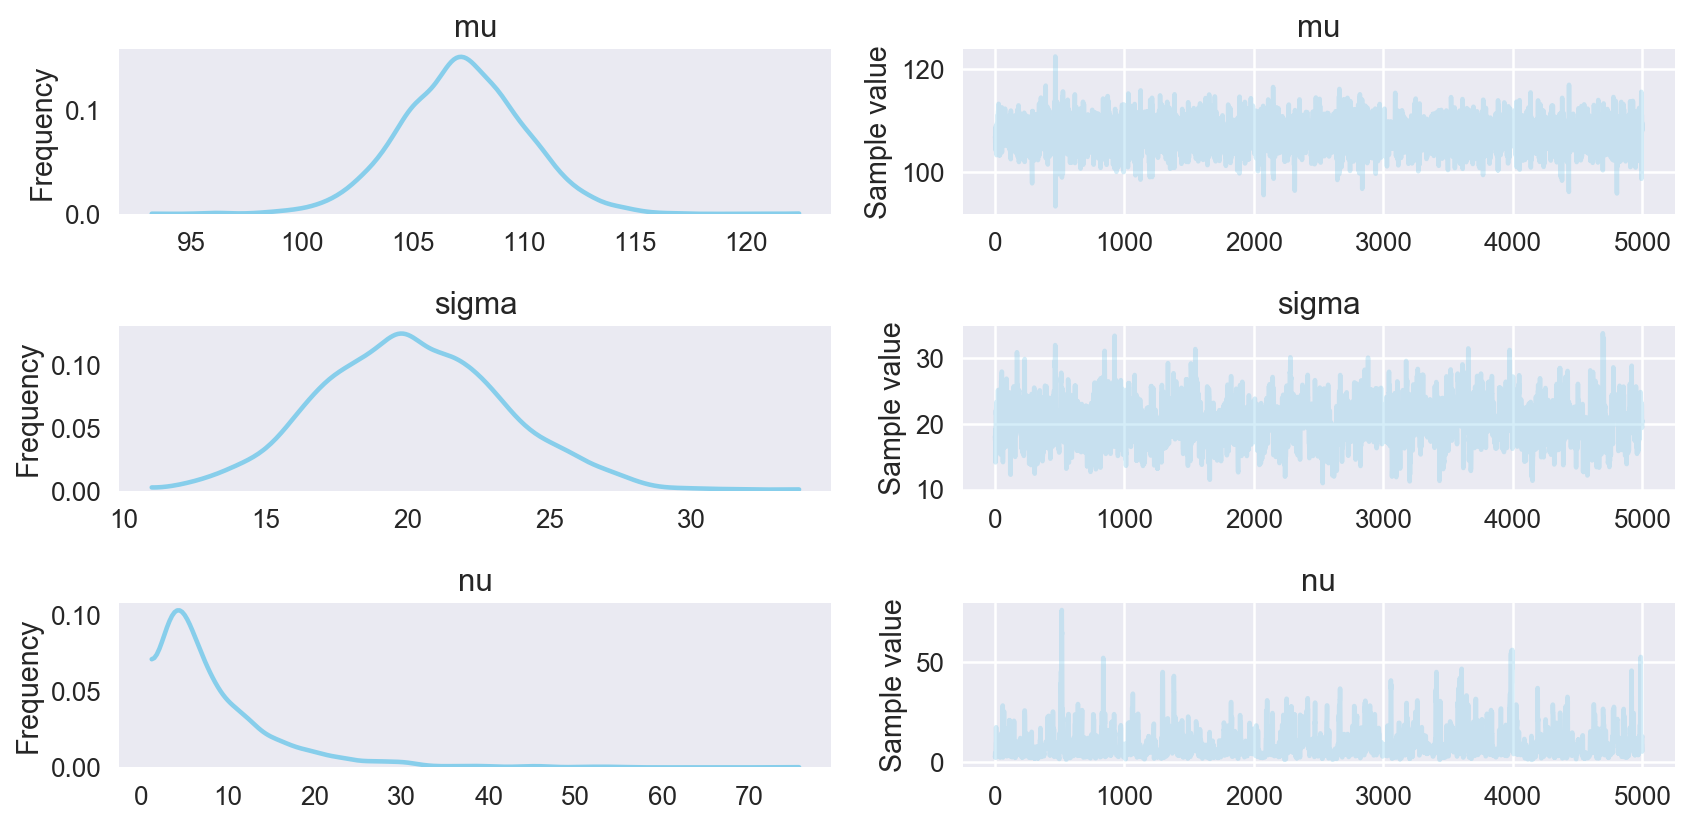

In [7]:
print pm.df_summary(trace)
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1189bae90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x112c52990>], dtype=object)

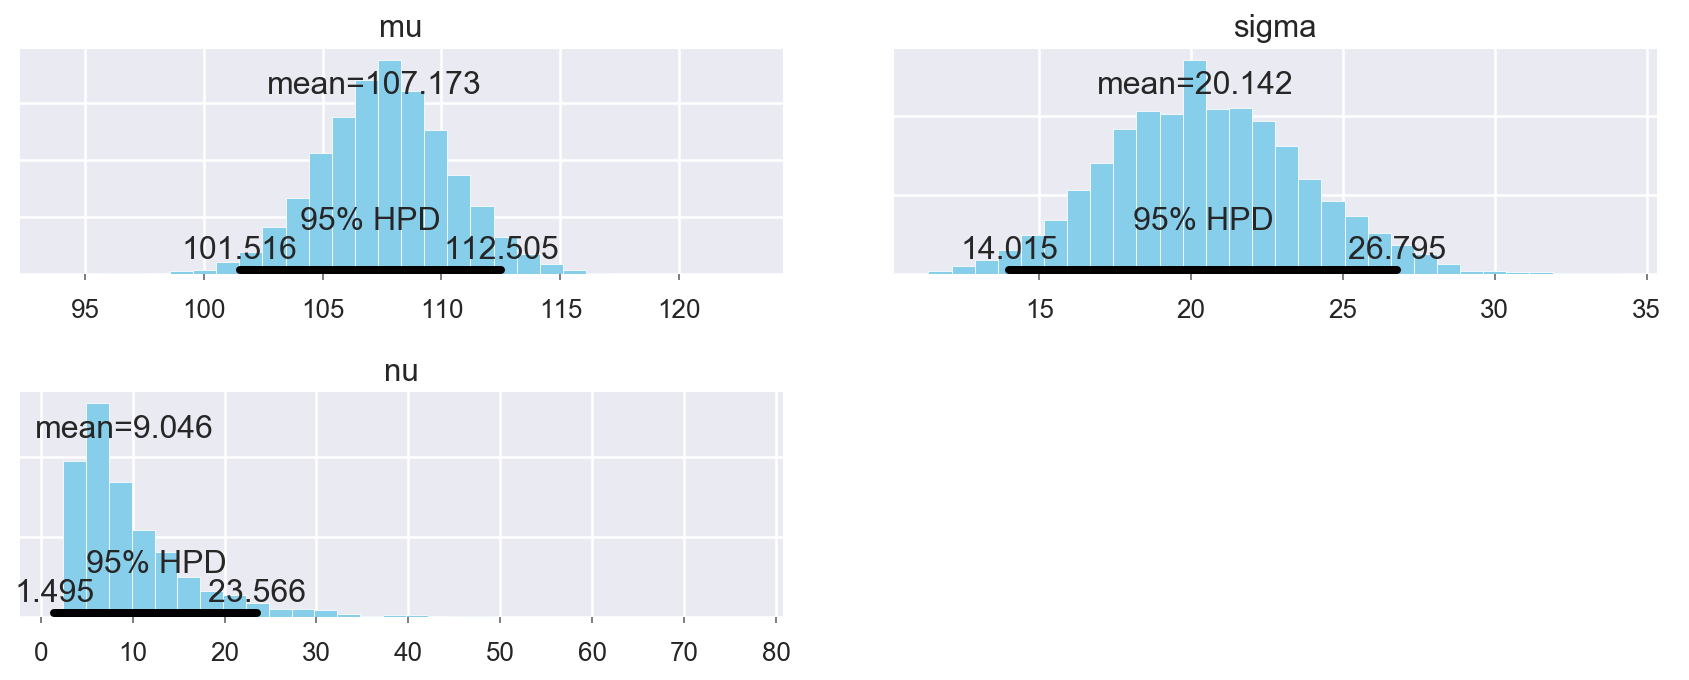

In [8]:
pm.plot_posterior(trace)